In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

df = pd.read_csv("churn_prediction.csv")

Koden innan cleaning

In [2]:
# Check for missing values in each column of the dataset
print(df.isna().sum())

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64


Cleaning

In [3]:
# Clean the dataset by replacing spaces in column names and handling missing values
df.columns = df.columns.str.replace(" ", "_")
df = df.dropna(subset=["gender"])
df["dependents"] = df["dependents"].fillna(0)
df[["city", "occupation"]] = df[["city", "occupation"]].fillna("unknown")

Korresponendsanalays

In [4]:
# Contingency Table of Gender and Age Groups vs. Balance Groups"

def assign_age_groups(age):
    if age <= 18:
        return "Children/Teens (1-18)"
    elif 19 <= age <= 39:
        return "Young Adults (19-39)"
    elif 40 <= age <= 54:
        return "Middle Aged Adults (40-54)"
    elif age >= 55:
        return "Older Adults (55+)"
    else:
        return None
    
def assign_balance_groups(balance):
    if 0 < balance <= 1000:
        return "Low Balance (0-1000$)"
    elif 1000 <= balance <= 5000:
        return "Medium Balance (1000-5000$)"
    elif 5001 <= balance <= 15000:
        return "High Balance (5001-15000$)"
    elif balance >= 15001:
        return "Very High Balance (> 15001$)"
    else:
        return None
    
df["balance_groups"] = df["current_month_balance"].apply(assign_balance_groups)
df["age_groups"] = df["age"].apply(assign_age_groups)   
 
kontingenstabell = pd.crosstab(
    index=[df["gender"], df["age_groups"]],
    columns=df["balance_groups"],
)

desired_order = ["Low Balance (0-1000$)", "Medium Balance (1000-5000$)", "High Balance (5001-15000$)", "Very High Balance (> 15001$)"]
kontingenstabell = kontingenstabell.reindex(columns=desired_order, fill_value=0)
kontingenstabell.index.name = "Gender and Age Group"

print(kontingenstabell.to_markdown(numalign="left", stralign="left"))

| Gender and Age Group                     | Low Balance (0-1000$)   | Medium Balance (1000-5000$)   | High Balance (5001-15000$)   | Very High Balance (> 15001$)   |
|:-----------------------------------------|:------------------------|:------------------------------|:-----------------------------|:-------------------------------|
| ('Female', 'Children/Teens (1-18)')      | 23                      | 319                           | 68                           | 14                             |
| ('Female', 'Middle Aged Adults (40-54)') | 197                     | 2202                          | 908                          | 295                            |
| ('Female', 'Older Adults (55+)')         | 179                     | 2002                          | 938                          | 331                            |
| ('Female', 'Young Adults (19-39)')       | 222                     | 2465                          | 942                          | 200                            

omvandling till procent

In [5]:
# Percentage Distribution Table of Gender, Age Groups, and Balance Groups with Row and Column Totals
procenttabell = kontingenstabell.div(kontingenstabell.sum().sum()).multiply(100)

print(procenttabell.to_markdown(numalign="left", stralign="left"))

rad_summor = procenttabell.sum(axis=1)
kolumn_summor = procenttabell.sum(axis=0)

print("\nRow Sums:")
for index, value in rad_summor.items():
    print(f"{index}: {value:.2f}%")

print("\nColumn Sums:")
for index, value in kolumn_summor.items():
    print(f"{index}: {value:.2f}%")

| Gender and Age Group                     | Low Balance (0-1000$)   | Medium Balance (1000-5000$)   | High Balance (5001-15000$)   | Very High Balance (> 15001$)   |
|:-----------------------------------------|:------------------------|:------------------------------|:-----------------------------|:-------------------------------|
| ('Female', 'Children/Teens (1-18)')      | 0.0825971               | 1.14559                       | 0.2442                       | 0.0502765                      |
| ('Female', 'Middle Aged Adults (40-54)') | 0.707462                | 7.90778                       | 3.26079                      | 1.0594                         |
| ('Female', 'Older Adults (55+)')         | 0.642821                | 7.18954                       | 3.36853                      | 1.18868                        |
| ('Female', 'Young Adults (19-39)')       | 0.797242                | 8.85226                       | 3.38289                      | 0.718236                       

Centrera/Standardisera data

In [6]:
# Centered Matrix of Standardized Residuals for Gender, Age Groups, and Balance Groups
cent_matris = procenttabell.copy()

for rad in procenttabell.index:
    for kolumn in procenttabell.columns:
        expected_value = rad_summor[rad] * kolumn_summor[kolumn] / 100
        cent_matris.at[rad, kolumn] = (procenttabell.at[rad, kolumn] - expected_value) / np.sqrt(expected_value)

cent_matris.index.name = "Gender and Age Group"
print(cent_matris.to_markdown(numalign="left", stralign="left"))

| Gender and Age Group                     | Low Balance (0-1000$)   | Medium Balance (1000-5000$)   | High Balance (5001-15000$)   | Very High Balance (> 15001$)   |
|:-----------------------------------------|:------------------------|:------------------------------|:-----------------------------|:-------------------------------|
| ('Female', 'Children/Teens (1-18)')      | -0.0167227              | 0.250908                      | -0.251188                    | -0.210594                      |
| ('Female', 'Middle Aged Adults (40-54)') | -0.0420429              | 0.0739841                     | -0.0916737                   | 0.000703414                    |
| ('Female', 'Older Adults (55+)')         | -0.0823633              | -0.0691687                    | 0.045626                     | 0.173471                       |
| ('Female', 'Young Adults (19-39)')       | 0.00748179              | 0.23219                       | -0.138189                    | -0.383804                      

SVD

In [7]:
# Singular Value Decomposition (SVD) and Inertia Calculation for Centered Matrix
U, Sigma, VT = np.linalg.svd(cent_matris, full_matrices=False)

total_variation = np.sum(Sigma ** 2)
inertia = (Sigma ** 2) / total_variation
print("\nInertia för varje komponent:")
print(inertia)

explained_variation = inertia * 100

np.set_printoptions(precision=2, suppress=True)
print(explained_variation)


Inertia för varje komponent:
[8.10668001e-01 1.75771420e-01 1.35605791e-02 2.08741886e-31]
[81.07 17.58  1.36  0.  ]


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


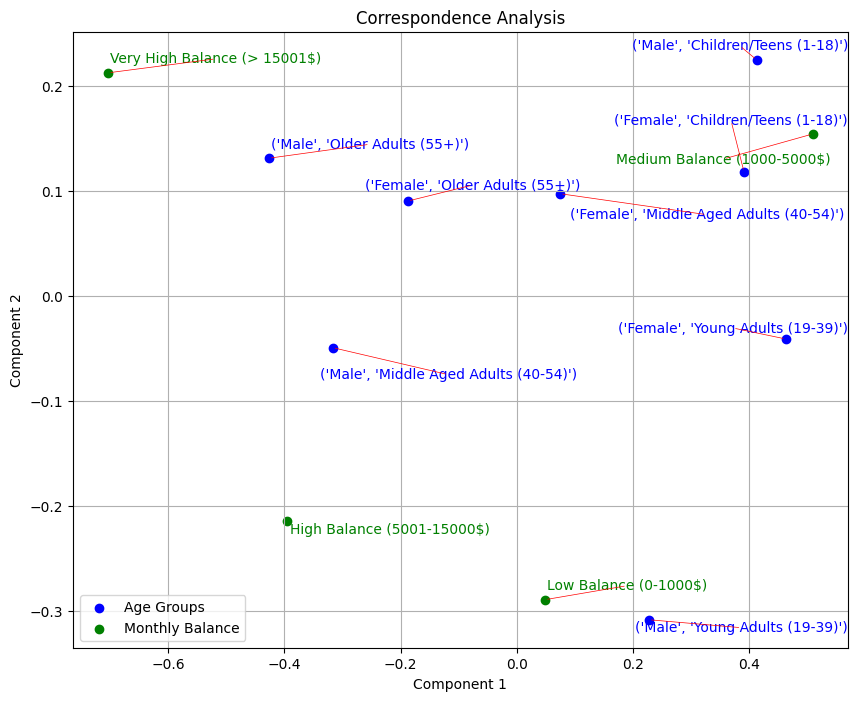

In [8]:
# Visualize the data using Matplotlib
row_coordinates = U[:, :2] * Sigma[:2]
col_coordinates = VT.T[:, :2] * Sigma[:2]

fig, ax = plt.subplots(figsize=(10, 8))

text = []

for i, (x, y) in enumerate(row_coordinates):
    ax.scatter(x, y, color="blue", label="Age Groups" if i == 0 else "")
    text.append(ax.text(x, y, str(kontingenstabell.index[i]), color="blue"))


for i, (x, y) in enumerate(col_coordinates):
    ax.scatter(x, y, color="green", label="Monthly Balance" if i == 0 else "")
    text.append(ax.text(x, y, str(kontingenstabell.columns[i]), color="green"))

adjust_text(text,
            only_move={"points": "y", "text": "xy"},
            autoalign="y",
            expand_points=(2, 2),
            expand_text=(2, 2),
            force_text=7.0,
            force_points=1.0,
            arrowprops=dict(arrowstyle="-", color="red", lw=0.5))

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Correspondence Analysis')
ax.legend()
ax.grid(True)

plt.show()

PCA

In [9]:
# Centering Financial Data by Subtracting Column Means
df_filtered = df[["current_month_balance", "previous_month_balance", 
                  "current_month_credit", "previous_month_credit", 
                  "current_month_debit", "previous_month_debit"]]


means = df_filtered.mean()
df_centered = df_filtered - means


print("\nOriginal data:")
print(df_filtered.head())
print("\nCentered data:")
print(df_centered.head())


Original data:
   current_month_balance  previous_month_balance  current_month_credit  \
0                1458.71                 1458.71                  0.20   
1                6496.78                 8787.61                  0.56   
2                5006.28                 5070.14                  0.61   
4                1157.15                 1677.16                  0.33   
5               15719.44                15349.75                  0.36   

   previous_month_credit  current_month_debit  previous_month_debit  
0                   0.20                 0.20                  0.20  
1                   0.56              5486.27                100.56  
2                   0.61              6046.73                259.23  
4                 714.61               588.62               1538.06  
5                   0.36               857.50                286.07  

Centered data:
   current_month_balance  previous_month_balance  current_month_credit  \
0           -5538.360394     

Kovariansmatrisen: visar hur stor skillnad det är mellan 2 variablar

In [10]:
cov_matris = np.cov(df_centered, rowvar=False)

print("\nKovariansmatrisen:")
print(cov_matris)


Kovariansmatrisen:
[[4.73e+08 4.40e+08 9.04e+07 9.08e+07 1.15e+08 8.23e+07]
 [4.40e+08 5.22e+08 9.75e+07 1.23e+08 9.10e+07 1.12e+08]
 [9.04e+07 9.75e+07 5.96e+09 3.61e+08 3.72e+09 1.96e+08]
 [9.08e+07 1.23e+08 3.61e+08 8.56e+08 2.28e+08 5.00e+08]
 [1.15e+08 9.10e+07 3.72e+09 2.28e+08 2.62e+09 1.77e+08]
 [8.23e+07 1.12e+08 1.96e+08 5.00e+08 1.77e+08 5.32e+08]]


egenvektor anger riktningen för komponenterna.
egenvärde representerar mängden av varians.

In [11]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matris)

print("\nEigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)


Eigenvalues:
[8.41e+09 1.29e+09 8.34e+08 5.32e+07 1.48e+08 2.30e+08]

Eigenvectors:
[[ 0.02 -0.31 -0.61 -0.72 -0.09  0.01]
 [ 0.02 -0.36 -0.62  0.68  0.09 -0.11]
 [ 0.84  0.08  0.02 -0.07  0.26 -0.47]
 [ 0.06 -0.7   0.4   0.02 -0.51 -0.28]
 [ 0.54  0.01 -0.05  0.11 -0.39  0.73]
 [ 0.04 -0.53  0.25 -0.07  0.71  0.39]]



Sorted eigenvalues:
[8.41e+09 1.29e+09 8.34e+08 2.30e+08 1.48e+08 5.32e+07]

Sorted eigenvectors:
[[ 0.02 -0.31 -0.61  0.01 -0.09 -0.72]
 [ 0.02 -0.36 -0.62 -0.11  0.09  0.68]
 [ 0.84  0.08  0.02 -0.47  0.26 -0.07]
 [ 0.06 -0.7   0.4  -0.28 -0.51  0.02]
 [ 0.54  0.01 -0.05  0.73 -0.39  0.11]
 [ 0.04 -0.53  0.25  0.39  0.71 -0.07]]

Chosen eigenvectors for the two most important components:
[[ 0.02 -0.31]
 [ 0.02 -0.36]
 [ 0.84  0.08]
 [ 0.06 -0.7 ]
 [ 0.54  0.01]
 [ 0.04 -0.53]]


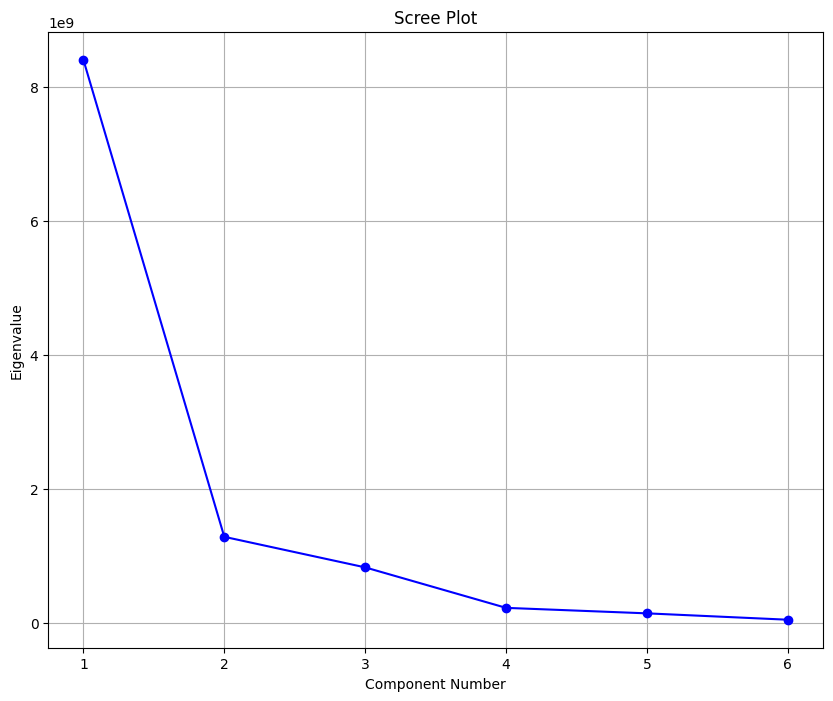

In [12]:
# Visualize the data using Matplotlib
sorted_index = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_index]
sorted_eigenvectors = eigenvectors[:, sorted_index]

print("\nSorted eigenvalues:")
print(sorted_eigenvalues)
print("\nSorted eigenvectors:")
print(sorted_eigenvectors)

n_components = 2
selected_eigenvectors = sorted_eigenvectors[:, :n_components]

print("\nChosen eigenvectors for the two most important components:")
print(selected_eigenvectors)

plt.figure(figsize=(10,8))
plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, "o-", markersize=6, color="b")
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(sorted_eigenvalues) + 1))
plt.grid(True)
plt.show()

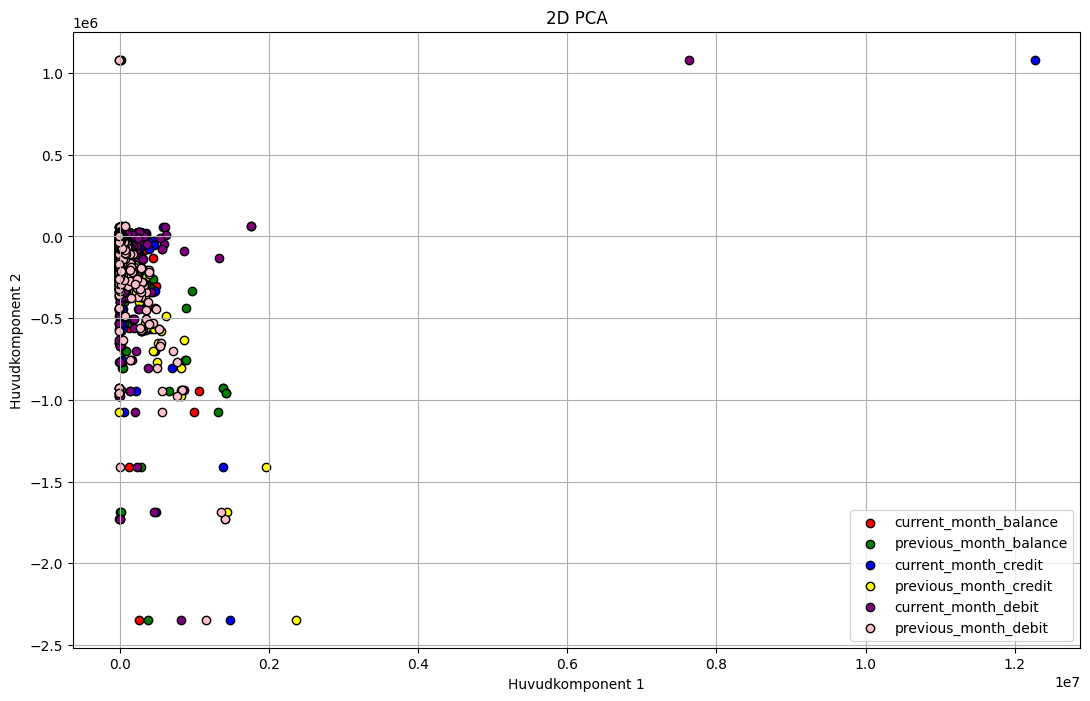

In [13]:
# Visualize the data using Matplotlib
eigenvector_subset = sorted_eigenvectors[:, :n_components]

df_reduced = np.dot(df_centered, eigenvector_subset)

features = ["current_month_balance", "previous_month_balance", 
            "current_month_credit", "previous_month_credit", 
            "current_month_debit", "previous_month_debit"]

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']

plt.figure(figsize=(13, 8))

for i, feature in enumerate(features):
    plt.scatter(df_centered[feature], df_reduced[:, 1], 
                color=colors[i], label=feature, edgecolor='k')

plt.xlabel('Huvudkomponent 1')
plt.ylabel('Huvudkomponent 2')
plt.title('2D PCA')
plt.legend()
plt.grid(True)
plt.show()

Huvudkomponent 1 = skillnad mellan all data
Huvudkomponent 2 = Hur mycket variation/skillnad den fångar ifrån datan som inte huvudkomponent 1 fångar.

In [14]:
selected_columns = [
    "current_balance",
    "current_month_credit",
    "current_month_debit",
    "current_month_balance",
    "average_monthly_balance_prevQ",
    "age"
]


selected_stats = df[selected_columns].describe().loc[['mean', 'std', 'min', 'max']]


rounded_stats = selected_stats.round(0).astype(int)

print(rounded_stats)

      current_balance  current_month_credit  current_month_debit  \
mean             6943                  3312                 3506   
std             22233                 77199                51167   
min             -5504                     0                    0   
max           1435873              12269845              7637857   

      current_month_balance  average_monthly_balance_prevQ  age  
mean                   6997                           7059   47  
std                   21756                          21628   17  
min                   -3374                           1429    1  
max                 1435873                        1435873   90  


In [15]:
from scipy.stats import ttest_ind


group_male = df[df['gender'] == 'Male']['current_month_balance']
group_female = df[df['gender'] == 'Female']['current_month_balance']


t_stat, p_value = ttest_ind(group_male, group_female, equal_var=False)


print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')
if p_value < 0.05:
    print('The small P-Value indicates that these differences are statistically significant between the genders')
else:
    print('The P-Values is not significant between the genders')

T-statistic: 3.9274751537247674
P-value: 8.604953969568239e-05
The small P-Value indicates that these differences are statistically significant between the genders


In [16]:
# Corrected variable names for clarity
q1_balance_male = df[df['gender'] == 'Male']['average_monthly_balance_prevQ2']
q2_balance_male = df[df['gender'] == 'Male']['average_monthly_balance_prevQ']

q1_balance_female = df[df['gender'] == 'Female']['average_monthly_balance_prevQ2']
q2_balance_female = df[df['gender'] == 'Female']['average_monthly_balance_prevQ']

# Perform Independent Samples T-Test for Q1 balances between genders
t_stat_q1, p_value_q1 = ttest_ind(q1_balance_male, q1_balance_female, equal_var=False)

# Perform Independent Samples T-Test for Q2 balances between genders
t_stat_q2, p_value_q2 = ttest_ind(q2_balance_male, q2_balance_female, equal_var=False)

(t_stat_q1, p_value_q1), (t_stat_q2, p_value_q2)

# Print the results
print(f'Q1 Balances T-Test between Genders:\nT-statistic: {t_stat_q1}\nP-value: {p_value_q1}')

if p_value_q1 < 0.05:
    print('The small P-Value indicates that these differences are statistically significant between the gender monthly balance from Q1')
else:
    print('The P-Values is not significant between the gender monthly balance from Q1')

print(f'\nQ2 Balances T-Test between Genders:\nT-statistic: {t_stat_q2}\nP-value: {p_value_q2}')

if p_value_q2 < 0.05:
    print('The small P-Value indicates that these differences are statistically significant between the gender monthly balance from Q2')
else:
    print('The P-Values is not significant between the gender monthly balance from Q2')

Q1 Balances T-Test between Genders:
T-statistic: 4.0281397962989685
P-value: 5.642233229608899e-05
The small P-Value indicates that these differences are statistically significant between the gender monthly balance from Q1

Q2 Balances T-Test between Genders:
T-statistic: 3.5713046728093314
P-value: 0.00035581278005912363
The small P-Value indicates that these differences are statistically significant between the gender monthly balance from Q2
